Emotion Analysis using SVM and K-Means Clustering

Objective: Develop an understanding of emotion recognition in text using Support Vector Machines (SVM) for classification and K-Means clustering for pattern discovery. This assignment will help you grasp the nuances of supervised and unsupervised learning techniques in Natural Language Processing (NLP). 

In [199]:
# cell 1
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn
# %pip install nltk
# %pip install imbalanced-learn
# %pip install gensim


  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/63/46/5feab9c524a380bfa9f9f1c0d065743280dca30b216ab4c7a231f22dbed7/gensim-4.3.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for smart-open>=1.8.1 from https://files.pythonhosted.org/packages/fc/d9/d97f1db64b09278aba64e8c81b5d322d436132df5741c518f3823824fae0/smart_open-6.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 35.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [127]:
#cell 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string

In [183]:
#cell 3

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans


Data Preparation: • Load and familiarize yourself with the EmotionLines dataset. • Conduct text preprocessing: tokenize, stem/lemmatize, and remove stop words. • Transform text into numerical representations using TF-IDF

In [129]:
#cell 4

train_df = pd.read_json('friends_train.json')
test_df = pd.read_json('friends_test.json')
holdout_df = pd.read_json('friends_dev.json')

print("Training Dataset:")
print(train_df.head(3))

print("\nTest Dataset:")
print(test_df.head(3))

print("\nHoldout Dataset:")
print(holdout_df.head(3))


Training Dataset:
                                                  0   \
0  {'speaker': 'Chandler', 'utterance': 'also I w...   
1  {'speaker': 'Chandler', 'utterance': 'Hey, Mon...   
2  {'speaker': 'Rachel', 'utterance': 'Hey!', 'em...   
3  {'speaker': 'Chandler', 'utterance': 'Good job...   
4  {'speaker': 'Joey', 'utterance': 'Okay, look, ...   

                                                  1   \
0  {'speaker': 'The Interviewer', 'utterance': 'Y...   
1  {'speaker': 'Monica', 'utterance': 'Hey-hey-he...   
2  {'speaker': 'Ross', 'utterance': 'Hi!', 'emoti...   
3  {'speaker': 'Joey', 'utterance': 'You liked it...   
4  {'speaker': 'Ross', 'utterance': 'What?! What ...   

                                                  2   \
0  {'speaker': 'Chandler', 'utterance': 'That I d...   
1  {'speaker': 'Chandler', 'utterance': 'Do I eve...   
2  {'speaker': 'Rachel', 'utterance': 'What are y...   
3  {'speaker': 'Chandler', 'utterance': 'Oh-ho-ho...   
4  {'speaker': 'Phoebe', 'ut

In [249]:
train_df.shape
# Assuming 'df' is your DataFrame
column_names = train_df.columns
print(column_names)


Index([                      0,                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12,                      13,
                            14,                      15,
                            16,                      17,
                            18,                      19,
                            20,                      21,
                            22,                      23,
                 'tokenized_0',           'tokenized_1',
                 'tokenized_2',           'tokenized_3',
                 'tokenized_4',           'tokenized_5',
                 'tokenized_6',           'tokenized_7',
                 'tokenized_8',           'tokenized_9',
                'tokenized_10',

In [248]:
test_df.shape

(200, 49)

In [247]:
holdout_df.shape

(80, 24)

In [130]:
#cell 5

train_df.info()
test_df.info()
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       720 non-null    object
 1   1       720 non-null    object
 2   2       720 non-null    object
 3   3       720 non-null    object
 4   4       720 non-null    object
 5   5       688 non-null    object
 6   6       655 non-null    object
 7   7       620 non-null    object
 8   8       579 non-null    object
 9   9       547 non-null    object
 10  10      520 non-null    object
 11  11      484 non-null    object
 12  12      444 non-null    object
 13  13      408 non-null    object
 14  14      367 non-null    object
 15  15      333 non-null    object
 16  16      292 non-null    object
 17  17      253 non-null    object
 18  18      224 non-null    object
 19  19      189 non-null    object
 20  20      142 non-null    object
 21  21      102 non-null    object
 22  22      79 non-null     ob

In [131]:
#cell 6a
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Chandler', 'utterance': 'also I w...","{'speaker': 'The Interviewer', 'utterance': 'Y...","{'speaker': 'Chandler', 'utterance': 'That I d...","{'speaker': 'The Interviewer', 'utterance': 'S...","{'speaker': 'Chandler', 'utterance': 'My dutie...","{'speaker': 'The Interviewer', 'utterance': 'N...","{'speaker': 'Chandler', 'utterance': 'I see.',...","{'speaker': 'The Interviewer', 'utterance': 'B...","{'speaker': 'Chandler', 'utterance': 'Good to ...","{'speaker': 'The Interviewer', 'utterance': 'W...",...,"{'speaker': 'Joey', 'utterance': 'But then who...","{'speaker': 'Rachel', 'utterance': 'You know? ...","{'speaker': 'Joey', 'utterance': 'No-no-no-no,...","{'speaker': 'Rachel', 'utterance': 'No, I-I-I-...","{'speaker': 'Joey', 'utterance': 'Ok!', 'emoti...","{'speaker': 'Joey', 'utterance': 'All right, w...","{'speaker': 'Joey', 'utterance': 'I'm gonna se...","{'speaker': 'Joey', 'utterance': 'I'll see you...","{'speaker': 'Rachel', 'utterance': 'Yeah, sure...",None
1,"{'speaker': 'Chandler', 'utterance': 'Hey, Mon...","{'speaker': 'Monica', 'utterance': 'Hey-hey-he...","{'speaker': 'Chandler', 'utterance': 'Do I eve...","{'speaker': 'Monica', 'utterance': 'Chris says...","{'speaker': 'Chandler', 'utterance': 'No way!'...","{'speaker': 'Monica', 'utterance': 'Yeah, appa...","{'speaker': 'Chandler', 'utterance': 'Just cof...","{'speaker': 'Monica', 'utterance': 'Got me.', ...","{'speaker': 'Chandler', 'utterance': 'Can I ge...","{'speaker': 'Monica', 'utterance': 'Hey, did y...",...,"{'speaker': 'Chandler', 'utterance': 'What, wh...","{'speaker': 'Phoebe', 'utterance': 'What?!', '...","{'speaker': 'Phoebe', 'utterance': 'He was wit...","{'speaker': 'Phoebe', 'utterance': 'Look, 'My...","{'speaker': 'Phoebe', 'utterance': 'Now that I...","{'speaker': 'Phoebe', 'utterance': 'He thinks ...","{'speaker': 'Chandler', 'utterance': 'You real...","{'speaker': 'Phoebe', 'utterance': 'Oh, totall...","{'speaker': 'Joey', 'utterance': 'Done.', 'emo...",None
2,"{'speaker': 'Rachel', 'utterance': 'Hey!', 'em...","{'speaker': 'Ross', 'utterance': 'Hi!', 'emoti...","{'speaker': 'Rachel', 'utterance': 'What are y...","{'speaker': 'Ross', 'utterance': 'Ah y'know, t...","{'speaker': 'Rachel', 'utterance': 'Oh.', 'emo...","{'speaker': 'Ross', 'utterance': 'Hi.', 'emoti...","{'speaker': 'Rachel', 'utterance': 'Hi.', 'emo...","{'speaker': 'Ross', 'utterance': 'Howd did it...","{'speaker': 'Rachel', 'utterance': 'Oh well, t...","{'speaker': 'Ross', 'utterance': 'Im so proud...",...,"{'speaker': 'Rachel', 'utterance': 'Yeah.', 'e...","{'speaker': 'Phoebe', 'utterance': 'Ameri-can....","{'speaker': 'Sergei', 'utterance': 'Ameri-ccan...","{'speaker': 'Phoebe', 'utterance': 'Ameri-can....","{'speaker': 'Sergei', 'utterance': 'Everybody!...",None,None,None,None,None
3,"{'speaker': 'Chandler', 'utterance': 'Good job...","{'speaker': 'Joey', 'utterance': 'You liked it...","{'speaker': 'Chandler', 'utterance': 'Oh-ho-ho...","{'speaker': 'Joey', 'utterance': 'Which part e...","{'speaker': 'Chandler', 'utterance': 'The whol...","{'speaker': 'Joey', 'utterance': 'Oh no-no-no,...","{'speaker': 'Chandler', 'utterance': 'I love t...","{'speaker': 'Joey', 'utterance': 'Hey, what ab...","{'speaker': 'Chandler', 'utterance': 'I was su...","{'speaker': 'Joey', 'utterance': 'You fell asl...",...,"{'speaker': 'Chandler', 'utterance': 'Dont go...","{'speaker': 'Chandler', 'utterance': 'Im sorr...","{'speaker': 'Chandler', 'utterance': 'Im so s...","{'speaker': 'Chandler', 'utterance': 'Look!', ...","{'speaker': 'Chandler', 'utterance': 'This guy...","{'speaker': 'Chandler', 'utterance': 'He fell ...","{'speaker': 'Chandler', 'utterance': 'Be mad a...","{'speaker': 'Chandler', 'utterance': 'Or, call...",None,None
4,"{'speaker': 'Joey', 'utterance': 'Okay, look, ...","{'speaker': 'Ross', 'utterance': 'What?! What ...","{'speaker': 'Phoebe', 'utterance': 'Yes, and i...","{'speaker': 'Phoebe', 'utt

In [132]:
#cell 6b
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Mark', 'utterance': 'Why do all y...","{'speaker': 'Rachel', 'utterance': 'Oh. Thats...","{'speaker': 'Rachel', 'utterance': 'Y'know wha...","{'speaker': 'Ross', 'utterance': 'It didnt.',...","{'speaker': 'Frank', 'utterance': 'Okay, so wh...","{'speaker': 'Joey', 'utterance': 'Now, wh-what...","{'speaker': 'Frank', 'utterance': 'Its so coo...","{'speaker': 'Ross', 'utterance': 'Yeah, yeah.'...","{'speaker': 'Joey', 'utterance': 'Why cant I ...","{'speaker': 'Ross', 'utterance': 'Dont ask me...",...,"{'speaker': 'Frank', 'utterance': 'Its out th...","{'speaker': 'Joey', 'utterance': 'Then you hol...","{'speaker': 'Frank', 'utterance': 'All right, ...","{'speaker': 'Joey', 'utterance': 'All right, c...",None,None,None,None,None,None
1,"{'speaker': 'Joey', 'utterance': 'Come on, Lyd...","{'speaker': 'Joey', 'utterance': 'Push!', 'emo...","{'speaker': 'Joey', 'utterance': 'Push 'em out...","{'speaker': 'Joey', 'utterance': 'Push 'em out...","{'speaker': 'Joey', 'utterance': 'Let's get th...","{'speaker': 'Joey', 'utterance': 'Let's I wa...","{'speaker': 'Joey', 'utterance': 'Push!', 'emo...","{'speaker': 'Joey', 'utterance': 'Push!', 'emo...",None,None,...,None,None,None,None,None,None,None,None,None,None
2,"{'speaker': 'Ross', 'utterance': 'Okay.', 'emo...","{'speaker': 'Rachel', 'utterance': 'Ross, didn...","{'speaker': 'Ross', 'utterance': 'Uhh, yes I d...","{'speaker': 'Ross', 'utterance': 'Okay, go lef...","{'speaker': 'Rachel', 'utterance': 'Okay, y'kn...","{'speaker': 'Ross', 'utterance': 'Oh okay, lif...","{'speaker': 'Ross', 'utterance': 'Straight up ...","{'speaker': 'Ross', 'utterance': 'You can do i...","{'speaker': 'Ross', 'utterance': 'You can do i...","{'speaker': 'Ross', 'utterance': 'Okay.', 'emo...",...,"{'speaker': 'Ross', 'utterance': 'Yes but too ...","{'speaker': 'Steve', 'utterance': 'Okay, fine,...","{'speaker': 'Ross', 'utterance': 'Ugh, can you...","{'speaker': 'Phoebe', 'utterance': 'Yeah. I re...",None,None,None,None,None,None
3,"{'speaker': 'Phoebe', 'utterance': 'Ohh!', 'em...","{'speaker': 'Monica', 'utterance': 'What?', 'e...","{'speaker': 'Phoebe', 'utterance': 'It kicked!...","{'speaker': 'Monica', 'utterance': 'Oh my God!...","{'speaker': 'Phoebe', 'utterance': 'Oh no wait...","{'speaker': 'Joey', 'utterance': 'Oh my God! I...","{'speaker': 'Monica', 'utterance': 'Oh wait, J...","{'speaker': 'Joey', 'utterance': 'Look, I know...","{'speaker': 'Joey', 'utterance': 'Theyre just...","{'speaker': 'Chandler', 'utterance': 'Youre c...",...,"{'speaker': 'Chandler', 'utterance': 'So uh, w...","{'speaker': 'Marjorie', 'utterance': 'I talk i...","{'speaker': 'Chandler', 'utterance': 'What a c...","{'speaker': 'Joey', 'utterance': 'So why dont...",None,None,None,None,None,None
4,"{'speaker': 'Joey', 'utterance': 'Previously o...","{'speaker': 'Monica', 'utterance': 'I dont kn...","{'speaker': 'Phoebe', 'utterance': 'Oh?!', 'em...","{'speaker': 'Monica', 'utterance': 'Yeah, but ...","{'speaker': 'Phoebe', 'utterance': 'Oh.', 'emo...","{'speaker': 'Joey', 'utterance': 'And its not...","{'speaker': 'Chandler', 'utterance': 'Yeah, it...","{'speaker': 'Monica', 'utterance': 'So you can...","{'speaker': 'Ross', 'utterance': 'Yeah, anythi...","{'speaker': 'Monica', 'utterance': 'Whats fis...",...,None,None,None,None,None,None,None,None,None,None


In [133]:
#cell 6c
holdout_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Phoebe', 'utterance': 'Oh my God,...","{'speaker': 'Monica', 'utterance': 'What?', 'e...","{'speaker': 'Ross', 'utterance': 'Or! Or, we c...","{'speaker': 'Chandler', 'utterance': 'Youre a...","{'speaker': 'Joey', 'utterance': 'Aww, man, no...","{'speaker': 'Chandler', 'utterance': 'Now, the...","{'speaker': 'Phoebe', 'utterance': 'Hey.', 'em...","{'speaker': 'All', 'utterance': 'Hey!', 'emoti...","{'speaker': 'Phoebe', 'utterance': 'Ohh, you g...","{'speaker': 'Rachel', 'utterance': 'Where?!', ...",...,"{'speaker': 'Monica', 'utterance': 'Well, next...","{'speaker': 'Joey', 'utterance': 'Yeah! Yeah! ...","{'speaker': 'Chandler', 'utterance': 'Thank yo...","{'speaker': 'Joey', 'utterance': 'No-no, thank...",None,None,None,None,None,None
1,"{'speaker': 'Joey', 'utterance': 'Hey Estelle,...","{'speaker': 'Estelle', 'utterance': 'Well! Wel...","{'speaker': 'Joey', 'utterance': 'What are you...","{'speaker': 'Estelle', 'utterance': 'Really?!'...","{'speaker': 'Joey', 'utterance': 'Yeah!', 'emo...","{'speaker': 'Estelle', 'utterance': 'Oh well, ...","{'speaker': 'Gary', 'utterance': 'Okay, you gu...","{'speaker': 'Ross', 'utterance': 'Yeah!!', 'em...","{'speaker': 'Chandler', 'utterance': 'Tonight?...",None,...,None,None,None,None,None,None,None,None,None,None
2,"{'speaker': 'Ross', 'utterance': 'Yes? Yes?! H...","{'speaker': 'Guy', 'utterance': 'Yeah, we were...","{'speaker': 'Ross', 'utterance': 'Oh-oh, your...","{'speaker': 'Ross', 'utterance': 'What exactly...","{'speaker': 'Ross', 'utterance': 'Perhaps, pe...","{'speaker': 'Guy', 'utterance': 'Uhh .', 'emot...","{'speaker': 'Ross', 'utterance': 'Ah Ah Get o...","{'speaker': 'Woman', 'utterance': 'Uh, actuall...","{'speaker': 'Ross', 'utterance': 'I find Mario...","{'speaker': 'Woman', 'utterance': 'Im sorry, ...",...,"{'speaker': 'Ross', 'utterance': 'Well I uh, I...",None,None,None,None,None,None,None,None,None
3,"{'speaker': 'Ross', 'utterance': 'You had no r...","{'speaker': 'Rachel', 'utterance': 'What?', 'e...","{'speaker': 'Ross', 'utterance': 'I was doing ...","{'speaker': 'Rachel', 'utterance': 'Hey, I was...","{'speaker': 'Ross', 'utterance': 'The point is...","{'speaker': 'Ross', 'utterance': 'I don't need...","{'speaker': 'Ross', 'utterance': 'It, it's too...","{'speaker': 'Ross', 'utterance': 'This ship ha...","{'speaker': 'Rachel', 'utterance': 'Alright, f...","{'speaker': 'Ross', 'utterance': 'Fine.', 'emo...",...,None,None,None,None,None,None,None,None,None,None
4,"{'speaker': 'Phoebe', 'utterance': 'Oh, it's s...","{'speaker': 'Joey', 'utterance': 'Yknow, Moni...","{'speaker': 'Phoebe', 'utterance': 'All in goo...","{'speaker': 'Phoebe', 'utterance': 'All in goo...","{'speaker': 'Phoebe', 'utterance': 'Oh shoot!'...","{'speaker': 'Phoebe', 'utterance': 'I left my ...","{'speaker': 'Phoebe', 'utterance': 'Well you c...","{'speaker': 'Joey', 'utterance': 'I dont have...","{'speaker': 'Phoebe', 'utterance': 'What?! The...","{'speaker': 'Joey', 'utterance': 'Why would th...",...,"{'speaker': 'Ross', 'utterance': 'Uh, what?', ...","{'speaker': 'Rachel', 'utterance': 'Yes! Shes...","{'speaker': 'Ross', 'utterance': 'WhatYoure ...","{'speaker': 'Ross', 'utterance': 'I mean shes...","{'speaker': 'Ross', 'utterance': 'Shell drive...","{'speaker': 'Mrs. Green', 'utterance': 'Hi Ros...","{'speaker': 'Ross', 'utterance': 'Hi roomie!',...",None,None,None


In [134]:
# cell 7
# Function to print columns and their respective count of missing values
def print_missing_values(df, dataset_name):
    print(f"{dataset_name} Dataset Columns and Missing Values:")
    for column in df.columns:
        missing_count = df[column].isna().sum()
        print(f"{column}: {missing_count} missing values")

# Apply the function to each dataset
print_missing_values(train_df, "Training")
print("\n")
print_missing_values(test_df, "Test")
print("\n")
print_missing_values(holdout_df, "Holdout")


Training Dataset Columns and Missing Values:
0: 0 missing values
1: 0 missing values
2: 0 missing values
3: 0 missing values
4: 0 missing values
5: 32 missing values
6: 65 missing values
7: 100 missing values
8: 141 missing values
9: 173 missing values
10: 200 missing values
11: 236 missing values
12: 276 missing values
13: 312 missing values
14: 353 missing values
15: 387 missing values
16: 428 missing values
17: 467 missing values
18: 496 missing values
19: 531 missing values
20: 578 missing values
21: 618 missing values
22: 641 missing values
23: 685 missing values


Test Dataset Columns and Missing Values:
0: 0 missing values
1: 0 missing values
2: 0 missing values
3: 0 missing values
4: 0 missing values
5: 12 missing values
6: 25 missing values
7: 38 missing values
8: 45 missing values
9: 60 missing values
10: 68 missing values
11: 74 missing values
12: 89 missing values
13: 98 missing values
14: 107 missing values
15: 117 missing values
16: 128 missing values
17: 137 missing valu

In [135]:
# Cell 8
# Ensure nltk punkt package is downloaded
# nltk.download('punkt')

# Updated Tokenization Function to Handle JSON Objects
def tokenize_utterances_from_json(cell):
    # Check if the cell is a dictionary and has the 'utterance' key
    if isinstance(cell, dict) and 'utterance' in cell:
        return word_tokenize(cell['utterance'])
    else:
        return []

# Columns that contain JSON objects with utterances
json_columns = list(range(24))  # Adjust this list based on your DataFrame (0 to 23)

# Apply tokenization to each JSON column
for col in json_columns:
    col_name = f'tokenized_{col}'
    train_df[col_name] = train_df[col].apply(tokenize_utterances_from_json)

# Display the results for verification
print("Modified Training DataFrame:")
print(train_df[[f'tokenized_{col}' for col in json_columns]].head())


Modified Training DataFrame:
                                         tokenized_0  \
0  [also, I, was, the, point, person, on, my, com...   
1                                   [Hey, ,, Mon, .]   
2                                           [Hey, !]   
3  [Good, job, Joe, !, Well, done, !, Top, notch, !]   
4  [Okay, ,, look, ,, I, think, we, have, to, tel...   

                                         tokenized_1  \
0          [You, mustve, had, your, hands, full, .]   
1  [Hey-hey-hey, ., You, wan, na, hear, something...   
2                                            [Hi, !]   
3     [You, liked, it, ?, You, really, liked, it, ?]   
4  [What, ?, !, What, is, with, everybody, ?, It...   

                                         tokenized_2  \
0                 [That, I, did, ., That, I, did, .]   
1                                   [Do, I, ever, .]   
2                   [What, are, you, doing, here, ?]   
3                             [Oh-ho-ho, ,, yeah, !]   
4  [Yes, ,, and, 

In [136]:
# cell 9

# Download the list of stopwords from NLTK
# nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to remove stop words
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Columns that contain tokenized utterances
tokenized_columns = [f'tokenized_{col}' for col in range(24)]  # Adjust as per your DataFrame

# Apply the function to remove stop words from each tokenized column
for col in tokenized_columns:
    train_df[col] = train_df[col].apply(remove_stopwords)

# Display the results for verification
print("DataFrame with Stop Words Removed:")
print(train_df[tokenized_columns].head())


DataFrame with Stop Words Removed:
                                         tokenized_0  \
0  [also, I, point, person, companys, transition...   
1                                   [Hey, ,, Mon, .]   
2                                           [Hey, !]   
3  [Good, job, Joe, !, Well, done, !, Top, notch, !]   
4  [Okay, ,, look, ,, I, think, tell, Rachel, mes...   

                                         tokenized_1  \
0                     [You, mustve, hands, full, .]   
1  [Hey-hey-hey, ., You, wan, na, hear, something...   
2                                            [Hi, !]   
3             [You, liked, ?, You, really, liked, ?]   
4  [What, ?, !, What, everybody, ?, Its, Thanksg...   

                      tokenized_2  \
0        [That, I, ., That, I, .]   
1                [Do, I, ever, .]   
2                       [What, ?]   
3          [Oh-ho-ho, ,, yeah, !]   
4  [Yes, ,, dying, wish, ring, .]   

                                         tokenized_3  \
0          [

In [137]:
# Cell 10
# Download WordNet data
# nltk.download('wordnet')

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Columns that contain tokenized and stop words-removed text
lemmatized_columns = [f'tokenized_{col}' for col in range(24)]  # Adjust as per your DataFrame

# Apply the function to perform lemmatization on each column
for col in lemmatized_columns:
    train_df[col] = train_df[col].apply(lemmatize_tokens)

# Display the results for verification
print("DataFrame after Lemmatization:")
print(train_df[lemmatized_columns].head())


DataFrame after Lemmatization:
                                         tokenized_0  \
0  [also, I, point, person, companys, transition...   
1                                   [Hey, ,, Mon, .]   
2                                           [Hey, !]   
3  [Good, job, Joe, !, Well, done, !, Top, notch, !]   
4  [Okay, ,, look, ,, I, think, tell, Rachel, mes...   

                                         tokenized_1  \
0                      [You, mustve, hand, full, .]   
1  [Hey-hey-hey, ., You, wan, na, hear, something...   
2                                            [Hi, !]   
3             [You, liked, ?, You, really, liked, ?]   
4  [What, ?, !, What, everybody, ?, Its, Thanksg...   

                      tokenized_2  \
0        [That, I, ., That, I, .]   
1                [Do, I, ever, .]   
2                       [What, ?]   
3          [Oh-ho-ho, ,, yeah, !]   
4  [Yes, ,, dying, wish, ring, .]   

                                         tokenized_3  \
0            [So

In [138]:
# Cell 11

# Define a function to remove punctuation and convert to lower case
def remove_punctuation_and_lower(tokens):
    return [token.lower() for token in tokens if token not in string.punctuation]

# Columns that contain lemmatized text
processed_columns = [f'tokenized_{col}' for col in range(24)]  # Adjust as per your DataFrame

# Apply the function to remove punctuation and convert to lower case
for col in processed_columns:
    train_df[col] = train_df[col].apply(remove_punctuation_and_lower)

# Display the results for verification
print("DataFrame after Removing Punctuation and Lowercasing:")
print(train_df[processed_columns].head())


DataFrame after Removing Punctuation and Lowercasing:
                                         tokenized_0  \
0  [also, i, point, person, companys, transition...   
1                                         [hey, mon]   
2                                              [hey]   
3           [good, job, joe, well, done, top, notch]   
4  [okay, look, i, think, tell, rachel, messed, d...   

                                         tokenized_1  \
0                         [you, mustve, hand, full]   
1  [hey-hey-hey, you, wan, na, hear, something, s...   
2                                               [hi]   
3                   [you, liked, you, really, liked]   
4  [what, what, everybody, its, thanksgiving, .....   

                tokenized_2  \
0        [that, i, that, i]   
1             [do, i, ever]   
2                    [what]   
3          [oh-ho-ho, yeah]   
4  [yes, dying, wish, ring]   

                                         tokenized_3  \
0               [so, lets, t

In [139]:
# Cell 12

# Repeat the preprocessing steps for test_df
for col in json_columns:
    col_name = f'tokenized_{col}'
    test_df[col_name] = test_df[col].apply(tokenize_utterances_from_json)

for col in tokenized_columns:
    test_df[col] = test_df[col].apply(remove_stopwords)

for col in lemmatized_columns:
    test_df[col] = test_df[col].apply(lemmatize_tokens)

for col in processed_columns:
    test_df[col] = test_df[col].apply(remove_punctuation_and_lower)

# Combine the tokens into strings for test_df
test_df['combined_text'] = test_df[processed_columns].apply(lambda row: ' '.join([' '.join(tokens) for tokens in row]), axis=1)


In [140]:
train_df_backup = train_df.copy()

In [141]:
# Cell 13

from sklearn.feature_extraction.text import TfidfVectorizer

# Combine the tokens into strings
train_df['combined_text'] = train_df[processed_columns].apply(lambda row: ' '.join([' '.join(tokens) for tokens in row]), axis=1)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the combined text
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['combined_text'])

# Now X_train_tfidf is ready for training a machine learning model
X_test_tfidf = tfidf_vectorizer.transform(test_df['combined_text'])


In [142]:
# Cell 14
# Step 1: Inspect the Combined Text
print("Combined Text (First 5 Rows):")
print(train_df['combined_text'].head())

# Step 2: Examine the TF-IDF Matrix
print("\nTF-IDF Matrix Shape:")
print(X_train_tfidf.shape)  # Should show (number of documents, number of unique terms)

# Inspecting some values from the TF-IDF matrix
print("\nTF-IDF Values (First 5 Rows):")
print(X_train_tfidf[0:5].toarray())

# Step 3: View Feature Names
print("\nSome Feature Names:")
print(tfidf_vectorizer.get_feature_names_out()[0:10])  # Print first 10 feature names


Combined Text (First 5 Rows):
0    also i point person companys transition kl-5 ...
1    hey mon hey-hey-hey you wan na hear something ...
2    hey hi what ah y'know building paper route i ....
3    good job joe well done top notch you liked you...
4    okay look i think tell rachel messed dessert w...
Name: combined_text, dtype: object

TF-IDF Matrix Shape:
(720, 5052)

TF-IDF Values (First 5 Rows):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Some Feature Names:
['00' '000' '10' '100' '11' '110' '112' '12' '1200' '13']


In [143]:
# Cell 15

# Inspect the combined text in train_df
print("Training Data (First 5 Rows of combined_text):")
print(train_df['combined_text'].head())

# Inspect the combined text in test_df
print("\nTest Data (First 5 Rows of combined_text):")
print(test_df['combined_text'].head())

# Verify the shape of train_df and test_df
print("\nShape of train_df:", train_df.shape)
print("Shape of test_df:", test_df.shape)




Training Data (First 5 Rows of combined_text):
0    also i point person companys transition kl-5 ...
1    hey mon hey-hey-hey you wan na hear something ...
2    hey hi what ah y'know building paper route i ....
3    good job joe well done top notch you liked you...
4    okay look i think tell rachel messed dessert w...
Name: combined_text, dtype: object

Test Data (First 5 Rows of combined_text):
0    why youre coffee mug number bottom oh thats ...
1    come lydia push push 'em push 'em harder harde...
2    okay ross n't say elevator uhh yes i n't okay ...
3    ohh what it kicked i think baby kicked oh god ...
4    previously friends i dont know exactly its-i...
Name: combined_text, dtype: object

Shape of train_df: (720, 49)
Shape of test_df: (200, 49)


SVM for Emotion Classification: • Construct an SVM classifier to categorize emotions in text data. • Optimize the classifier by experimenting with different kernels and hyperparameters. • Validate the model using cross-validation and compute classification metrics. 

preparing data before proceeding with SVM classifier Training

In [259]:
#Cell 16 - TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Adjusting parameters of TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_df=0.8, min_df=0.01, max_features=50000000000000)

# Apply TF-IDF to the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['combined_text'])

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test_df['combined_text'])

# Define the extract_emotion function
def extract_emotion(row):
    if isinstance(row[0], dict) and 'emotion' in row[0]:
        return row[0]['emotion']
    return None

# Extracting Emotion Labels for Training and Test Data
y_train = train_df.apply(extract_emotion, axis=1)
y_test = test_df.apply(extract_emotion, axis=1)

# Verifying the extracted emotion labels and shapes
print("Extracted Emotion Labels for Training Data (First 10 Rows):")
print(y_train.head(10))
print("\nNumber of Rows with no Emotion Label in Training Data:", y_train.isna().sum())
print("\nShape of TF-IDF Matrix for Training Data:", X_train_tfidf.shape)
print("Length of y_train:", len(y_train))

print("\nExtracted Emotion Labels for Test Data (First 10 Rows):")
print(y_test.head(10))
print("\nNumber of Rows with no Emotion Label in Test Data:", y_test.isna().sum())
print("\nShape of TF-IDF Matrix for Test Data:", X_test_tfidf.shape)
print("Length of y_test:", len(y_test))


Extracted Emotion Labels for Training Data (First 10 Rows):
0        neutral
1        neutral
2    non-neutral
3            joy
4        neutral
5        neutral
6          anger
7    non-neutral
8            joy
9          anger
dtype: object

Number of Rows with no Emotion Label in Training Data: 0

Shape of TF-IDF Matrix for Training Data: (720, 1071)
Length of y_train: 720

Extracted Emotion Labels for Test Data (First 10 Rows):
0       surprise
1        neutral
2        neutral
3       surprise
4        neutral
5    non-neutral
6    non-neutral
7    non-neutral
8    non-neutral
9        neutral
dtype: object

Number of Rows with no Emotion Label in Test Data: 0

Shape of TF-IDF Matrix for Test Data: (200, 1071)
Length of y_test: 200


In [261]:
#Cell 17

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC


# Print the shape of the original training data
print("Original training data shape (features):", X_train_tfidf.shape)
print("Original training data shape (labels):", y_train.shape)

# Applying SMOTE to Training Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Print the shape of the training data after applying SMOTE
print("Resampled training data shape (features):", X_train_smote.shape)
print("Resampled training data shape (labels):", y_train_smote.shape)

# Initialize the SVM classifier with class weights
svm_classifier = SVC()
svm_classifier.fit(X_train_smote, y_train_smote)

# Optionally, you can also print a few samples of the resampled labels to see the class distribution
print("Sample of resampled labels:", y_train_smote[:15])

# Count records for each label before SMOTE
label_counts_before = y_train.value_counts()
print("Label counts before SMOTE:")
print(label_counts_before)

# Count records for each label after SMOTE
label_counts_after = y_train_smote.value_counts()
print("Label counts after SMOTE:")
print(label_counts_after)



Original training data shape (features): (720, 1071)
Original training data shape (labels): (720,)
Resampled training data shape (features): (2648, 1071)
Resampled training data shape (labels): (2648,)
Sample of resampled labels: 0         neutral
1         neutral
2     non-neutral
3             joy
4         neutral
5         neutral
6           anger
7     non-neutral
8             joy
9           anger
10            joy
11          anger
12        neutral
13       surprise
14       surprise
dtype: object
Label counts before SMOTE:
neutral        331
joy            128
non-neutral    107
surprise        82
sadness         26
anger           23
disgust         14
fear             9
Name: count, dtype: int64
Label counts after SMOTE:
neutral        331
non-neutral    331
joy            331
anger          331
surprise       331
sadness        331
disgust        331
fear           331
Name: count, dtype: int64


Training SVM Classifier

Improving the model

In [262]:
# Cell 18

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Try different C values
    'gamma': ['scale', 'auto', 0.1],  # Try different gamma values
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': [None, {'neutral': 1, 'non-neutral': 10, 'joy': 10, 'anger': 15, 'surprise': 20, 'sadness': 25, 'disgust': 30, 'fear': 35}]
}

# Create the SVM classifier
svm_classifier = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=2, scoring='accuracy')


# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_classifier = grid_search.best_estimator_

# Evaluate the best classifier on the test data
y_pred_best = best_classifier.predict(X_test_tfidf)
print(y_pred_best)
print("Best Classifier Classification Report:")
print(classification_report(y_test, y_pred_best, zero_division=1))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_best))


['neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'non-neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 '

• K-Means Clustering: • Implement K-Means clustering on the preprocessed text data. • Identify the optimal number of clusters with methods like the elbow technique. • Interpret the clusters to find patterns corresponding to different emotions. 

Find Optimal Number of Clusters using the Elbow Method

[655.4705688133879, 649.3283405995015, 643.4131003268017, 639.8908318651154, 636.3106511105982, 633.3067465368739, 631.3294981768337, 629.8941007984944, 626.3272996407272, 625.4080868965023, 625.487501928827, 621.4406710327789, 620.3654869474133, 618.6636944871973]


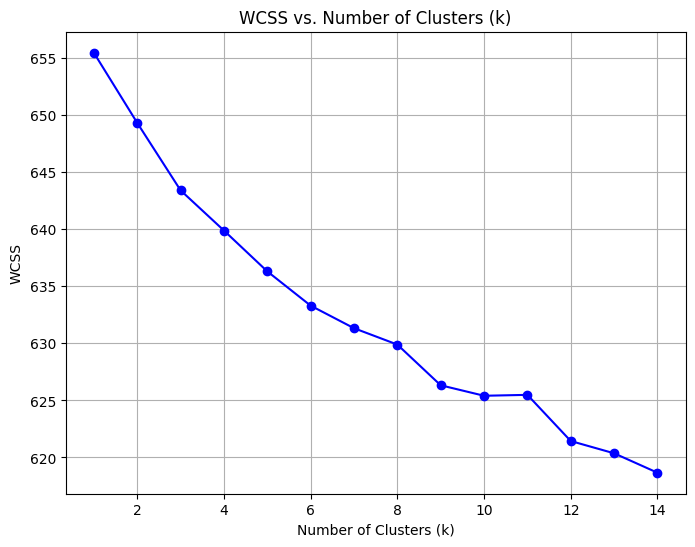

In [189]:
# Cell 19

# Using the TF-IDF features (X_train_tfidf) to find optimal clusters
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train_tfidf)
    wcss.append(kmeans.inertia_)
print(wcss)

# Plot the WCSS values to observe the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='-', color='b')
plt.title('WCSS vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Implement K-Means Clustering

In [150]:
# Cell 20

# Choose the optimal number of clusters from the elbow method
optimal_clusters = 11  # Replace this with the number you find optimal

# Implementing K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_train_tfidf)

# Print the first few cluster assignments
print("First few cluster assignments:", y_kmeans[:12])


First few cluster assignments: [ 1  7  7  1  3  5  6  8  9  5  6 10]


Interpret the Clusters

In [190]:
# Cell 21

# Function to print top terms per cluster
def print_top_terms_per_cluster(vectorizer, kmeans, n_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    for i in range(optimal_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :n_terms]:
            print(' %s' % terms[ind], end='')
        print()

# Print top terms per cluster
print_top_terms_per_cluster(tfidf_vectorizer, kmeans)


Cluster 0: okay right ll all right all go na know gon na gon
Cluster 1: you know okay one yeah mean what it like well
Cluster 2: na gon gon na re re gon re gon na you you re know oh
Cluster 3: whoa don you whoa whoa oh come say think get so
Cluster 4: yeah they oh yeah yeah they re phoebe re hi it you
Cluster 5: hey hey hey hey hey hey you oh what re yeah know well
Cluster 6: wedding oh happened don what know you story chandler monica
Cluster 7: got that hey get go okay you joey oh how
Cluster 8: oh god look oh god guy ok what looking like you
Cluster 9: we it okay re we re no you that know yeah
Cluster 10: no no no no no no no no no no oh okay know you that oh no no


Model Insights: • Analyze the performance of the SVM classifier and the clusters formed by K-Means. • Compare and contrast the results obtained from both SVM and K-Means. • Offer insights into the emotional trends captured by the models. 

In [263]:
# Cell 22

# Print the classification report and accuracy of the SVM classifier
print("SVM Classifier - Classification Report on Test Dataset:")
print(classification_report(y_test, y_pred_test, zero_division=1))
print("SVM Classifier - Accuracy Score on Test Dataset:")
print(accuracy_score(y_test, y_pred_test))

SVM Classifier - Classification Report on Test Dataset:
              precision    recall  f1-score   support

       anger       1.00      0.00      0.00         9
     disgust       1.00      0.00      0.00         1
        fear       1.00      0.00      0.00         2
         joy       1.00      0.00      0.00        24
     neutral       0.54      1.00      0.70       107
 non-neutral       1.00      0.03      0.06        35
     sadness       1.00      0.00      0.00         4
    surprise       1.00      0.00      0.00        18

    accuracy                           0.54       200
   macro avg       0.94      0.13      0.09       200
weighted avg       0.75      0.54      0.38       200

SVM Classifier - Accuracy Score on Test Dataset:
0.54


In [220]:
# Cell 23

# Assuming you have clusters and emotion labels defined
cluster_emotion_mapping = {
    0: "joy",
    1: "non-neutral",# neutral 
    2: "non-neutral",# neutral or joy
    3: "non-neutral",# non-neutral
    5: "surprise",# surprise
    6: "joy",# joy
    7: "joy",# joy
    8: "neutral",# neutral
    9: "neutral",# neutral
    10: "neutral"# neutral
    
    # Add mappings for other clusters as needed
}

# Assign emotions to clusters based on your criteria
cluster_emotions = {}
for cluster_id, emotion_label in cluster_emotion_mapping.items():
    cluster_emotions[cluster_id] = emotion_label

# Print cluster-emotion assignments
for cluster_id, emotion in cluster_emotions.items():
    print(f"Cluster {cluster_id}: Emotion - {emotion}")


Cluster 0: Emotion - joy
Cluster 1: Emotion - non-neutral
Cluster 2: Emotion - non-neutral
Cluster 3: Emotion - non-neutral
Cluster 5: Emotion - surprise
Cluster 6: Emotion - joy
Cluster 7: Emotion - joy
Cluster 8: Emotion - neutral
Cluster 9: Emotion - neutral
Cluster 10: Emotion - neutral


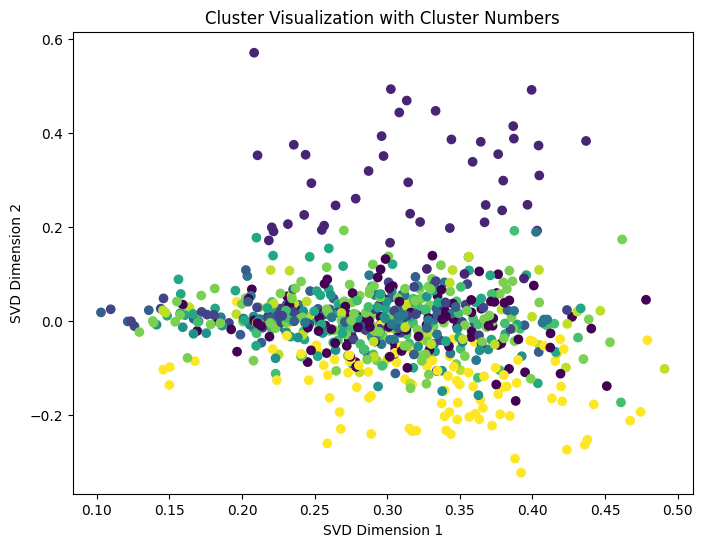

In [233]:
# Cell 24

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X_train_tfidf' is your TF-IDF matrix
# Assuming 'cluster_labels' contains cluster assignments
# Assuming 'cluster_emotions' contains emotion labels

# Map emotion labels to numeric values
emotion_to_numeric = {
    "joy": 0,
    "non-neutral": 1,
    "neutral": 2,
    "surprise": 3,
    "anger": 4,
    "sadness": 5,
    "disgust": 6,
    "fear": 7
}

# Convert emotion labels to numeric values based on the mapping
numeric_emotions = [emotion_to_numeric[emotion] for emotion in cluster_emotions.values()]

# Perform Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train_tfidf)

# Create a scatter plot to visualize clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_kmeans, cmap='viridis')

# # Create a legend with cluster numbers
# legend_labels = [f"Cluster {label}" for label in cluster_emotions.keys()]  # Use cluster numbers instead of emotion labels

# # Add the legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in scatter.cmap(np.unique(scatter.to_rgba(numeric_emotions)))]
# plt.legend(handles, legend_labels, title='Cluster Legend', loc='upper right')

plt.title("Cluster Visualization with Cluster Numbers")
plt.xlabel("SVD Dimension 1")
plt.ylabel("SVD Dimension 2")
plt.show()


In [235]:
# Assuming 'y_kmeans' contains K-Means cluster assignments (0 to 10)
# Assuming 'cluster_emotion_mapping' is the dictionary defined in Cell 23

# Create an empty list to store aligned emotional labels
aligned_emotional_labels = []

# Iterate through K-Means cluster assignments
for cluster_assignment in y_kmeans:
    # Map the cluster assignment to the corresponding emotional label
    emotional_label = cluster_emotion_mapping.get(cluster_assignment, "Unknown")
    # Append the aligned emotional label to the list
    aligned_emotional_labels.append(emotional_label)

# Verify the aligned emotional labels by printing them
print("Aligned Emotional Labels:")
print(aligned_emotional_labels)


Aligned Emotional Labels:
['non-neutral', 'joy', 'joy', 'non-neutral', 'non-neutral', 'surprise', 'joy', 'neutral', 'neutral', 'surprise', 'joy', 'neutral', 'non-neutral', 'joy', 'joy', 'neutral', 'neutral', 'neutral', 'joy', 'non-neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'joy', 'Unknown', 'joy', 'non-neutral', 'joy', 'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'non-neutral', 'joy', 'joy', 'neutral', 'joy', 'joy', 'non-neutral', 'joy', 'joy', 'neutral', 'neutral', 'joy', 'neutral', 'joy', 'neutral', 'neutral', 'non-neutral', 'non-neutral', 'non-neutral', 'neutral', 'joy', 'neutral', 'non-neutral', 'joy', 'surprise', 'neutral', 'joy', 'joy', 'non-neutral', 'non-neutral', 'joy', 'joy', 'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'joy', 'neutral', 'joy', 'neutral', 'neutral', 'non-neutral', 'neutral', 'non-neutral', 'neutral', 'neutral', 'non-neutral', 'non-neutral', 'neutral', 'joy', 'neutral', 'neutral', 'non-neutral', 'non-neutral', 'neutral', 'joy', 'j

In [242]:
import pandas as pd

# Assuming you have the JSON data loaded into a Python object called 'data'
# 'data' should be a list of dictionaries, where each dictionary represents a JSON object

# Initialize lists to store data for each column
speakers = []
emotions = []
svm_predicted_emotions = []
k_means_clusters = []

# Iterate through each JSON object in the 'data' list
for json_obj in data:
    # Extract relevant information from the JSON object
    speaker = json_obj['speaker']  # Replace 'document_id' with the actual key in your JSON data
    emotion = json_obj['emotion']  # Replace 'original_emotion' with the actual key
    svm_predicted_emotion = json_obj['y_pred_best']  # Replace 'svm_predicted_emotion' with the actual key
    k_means_cluster = json_obj['cluster_emotions']  # Replace 'k_means_cluster' with the actual key
    
    # Append the extracted data to the respective lists
    speakers.append(speaker)
    emotions.append(emotion)
    svm_predicted_emotions.append(svm_predicted_emotion)
    k_means_clusters.append(k_means_cluster)

# Create a DataFrame to store the findings
findings_df = pd.DataFrame({
    'Speaker': document_ids,
    'Emotion': original_emotions,
    'SVM Predicted Emotion': svm_predicted_emotions,
    'K-Means Cluster': k_means_clusters,
    'SVM Matches K-Means': (svm_predicted_emotions == k_means_clusters)
})

# Display the first few rows of the findings DataFrame
print("Table summarizing the findings:")
print(findings_df.head())


NameError: name 'data' is not defined

In [ ]:
import pandas as pd

# Assuming you have a DataFrame 'df' containing the JSON objects

# Create empty lists to store the data
document_ids = []
original_emotions = []
svm_predicted_emotions = []
y_kmeans = []
aligned_emotional_labels = []

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Extract the relevant information from the JSON objects in each row
    document_id = index  # You can use the DataFrame index as Document ID or index
    original_emotion = row['emotion']  # Assuming 'emotion' is the column with original emotion labels
    svm_predicted_emotion = y_train[index] #row['svm_predicted_emotion']  # Replace with the actual column name
    k_means_cluster = cluster_assignments[index] #row['k_means_cluster']  # Replace with the actual column name
    aligned_emotional_label = aligned_emotional_labels[index] #row['aligned_emotional_label']  # Replace with the actual column name
    
    # Append the data to the respective lists
    document_ids.append(document_id)
    original_emotions.append(original_emotion)
    svm_predicted_emotions.append(svm_predicted_emotion)
    y_kmeans.append(k_means_cluster)
    aligned_emotional_labels.append(aligned_emotional_label)

# Create a DataFrame to store the findings
findings_df = pd.DataFrame({
    'Document ID': document_ids,
    'Original Emotion': original_emotions,
    'SVM Predicted Emotion': svm_predicted_emotions,
    'K-Means Cluster': y_kmeans,
    'SVM Matches K-Means': (svm_predicted_emotions == aligned_emotional_labels)
})

# You can also add additional columns to the DataFrame if needed, such as TF-IDF scores or document text.

# Display the table
print("Table summarizing the findings:")
print(findings_df)


In [154]:
# Pseudocode - Replace with your analysis
print("Comparative Analysis:")
print("1. SVM Analysis: [Your observations and analysis here]")
print("2. K-Means Analysis: [Your observations and analysis here]")
print("3. Comparison: [Your comparison of SVM and K-Means here]")

Comparative Analysis:
1. SVM Analysis: [Your observations and analysis here]
2. K-Means Analysis: [Your observations and analysis here]
3. Comparison: [Your comparison of SVM and K-Means here]


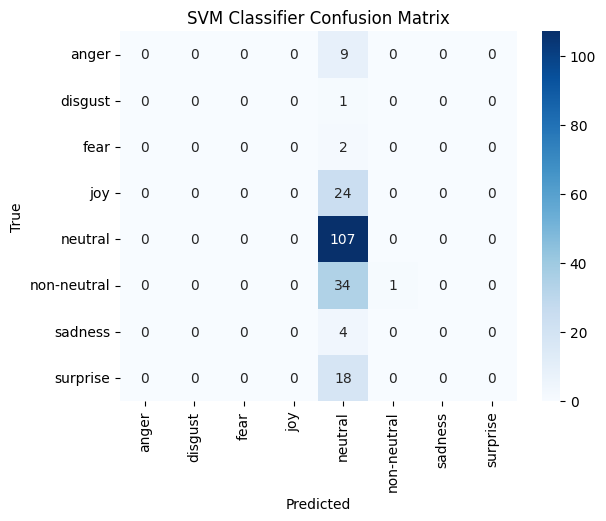

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test, labels=svm_classifier.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('SVM Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [156]:
# Pseudocode - Replace with your insights
print("Emotional Trends Insights:")
print("1. Insights from SVM: [Your insights from SVM here]")
print("2. Insights from K-Means: [Your insights from K-Means here]")
print("3. Overall Emotional Trends: [Your combined insights here]")


Emotional Trends Insights:
1. Insights from SVM: [Your insights from SVM here]
2. Insights from K-Means: [Your insights from K-Means here]
3. Overall Emotional Trends: [Your combined insights here]
